# reliability.space
# simplified reliability prediction
# Bearing:     solid lubricant wear model

by Matthias Schubert, 2021-09-20

For ESA RFP 17225

## General model

Solid lubricant wear modelling is described taking example in a ball bearing. The modelling is applicable to other cases of solid lubricant wear, however, the number of revolution has to be substituted with another measure of sliding distance. 
For solid lubricant reservoir wear (e.g. cage of a ball bearing), the limit state function for the adhesive wear model is formulated as follows:

$g\left( {\bf{X}} \right) = {V_{{\rm{limit}}}} - \Theta  \cdot \sum\limits_{i = 1}^{{n_p}} {{K_{H,i}} \cdot {\alpha _i} \cdot re{v_i}}$

Where $\alpha$ denotes the average work of ball/cage interaction forces per revolution and $rev_i$ the number of revolutions in time interval $i$ . The parameter $\alpha$ will typically be estimated from tests and is, thus dependent on the wear rate $K_H$ , which is used to estimate $\alpha$ from the test results. Therefore, $K_H$ cannot be easily taken out of the sum.

In [1]:
#   IMPORTs
from IPython.display import display 
import ipywidgets as widgets 
from ipywidgets import interact, Layout
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
from ipywidgets import interact
import nbinteract as nbi

In [2]:
def proF(E_Vlim,COV_Vlim,Dist_Vlim,E_KH,COV_KH,Dist_KH,E_alpha,COV_alpha,Dist_alpha,E_MU,COV_MU,Dist_MU,E_nrev):
    
    E_vlimit_val = float(E_Vlim)
    nu_vlimit_val = float(COV_Vlim)
    E_KH_val = float(E_KH)
    nu_KH_val = float(COV_KH)
    E_alpha_val = float(E_alpha)
    nu_alpha_val = float(COV_alpha)
    E_theta_val = float(E_MU)
    nu_theta_val = float(COV_MU)
    rev_val = float(E_nrev)


    rev_min=rev_val*0.5;  #for plotting
    rev_max=rev_val*2;  #for plotting

    #revolutions per hour
    rev_hour=6;
    ######################################################

    # Transfer parameters
    E_x1 = E_vlimit_val;
    nu_x1 = nu_vlimit_val;
    nu_KH_alpha = E_KH_val*nu_KH_val * E_alpha_val*nu_alpha_val;
    var_KH = (E_KH_val*nu_KH_val)**2;
    var_alpha = (E_alpha_val*nu_alpha_val)**2;
    var_KH_alpha = var_KH*var_alpha + var_KH*E_alpha_val**2 + var_alpha*E_KH_val**2;
    E_x2 = (E_KH_val*E_alpha_val + nu_KH_alpha)*rev_val;
    nu_x2 = 1/E_x2*rev_val*np.sqrt(var_KH_alpha);
  
    #Simplifid model - next step is to replace by FORM using
    #Hackl toolbox Phyton (documentation: http://hackl.github.io/pyre/; Code: http://github.com/hackl/pyre <http://github.com/hackl/pyre )
    pf = norm.cdf((np.log(E_theta_val) - np.log(E_x1/E_x2) + 0.5*(np.log(nu_x1**2 + 1) - np.log(nu_x2**2 + 1) - np.log(nu_theta_val**2 + 1))) / np.sqrt(np.log( nu_theta_val**2 + 1 ) + 
    np.log( nu_x1**2 + 1 ) + np.log( nu_x2**2 + 1 )));


    rev_mat=np.linspace(rev_min,rev_max,50);

    pf_mat=[]
    for i_rev in range(rev_mat.shape[0]):
            E_x2 = (E_KH_val*E_alpha_val + nu_KH_alpha)*rev_mat[i_rev];
            nu_x2 = 1/E_x2*rev_mat[i_rev]*np.sqrt(var_KH_alpha);

            pf_mat.append( norm.cdf((np.log(E_theta_val) - np.log(E_x1/E_x2) + 0.5*(np.log(nu_x1**2 + 1) -  np.log(nu_x2**2 + 1) - np.log(nu_theta_val**2 + 1))) / np.sqrt(np.log( nu_theta_val**2 + 1 ) + np.log( nu_x1**2 + 1 ) + np.log( nu_x2**2 + 1 ))) )

    %matplotlib inline
    plt.plot(np.log10(rev_mat), pf_mat,'b-')
    plt.plot(np.log10(rev_val), pf,'ro')
    plt.xlabel('$log_{10}$(number of revolutions)\n solid lubricant wear model')
    plt.ylabel('Probability of failure $P_f(rev)$')
    plt.yscale('log')
        
   
    return 'The probability of failure is pf={}'.format(pf)

In [3]:
from IPython.display import HTML

In [4]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Input values for reliability prediction
#### -Limiting value (worn volume), $V_{lim}$ $[m^3]$
#### -Specific wear rate, $K_H$ $[Pa^{-1}=m^2/N]$
#### -Ball-cage interaction, $\alpha$ $[N/m]$
#### -Model uncertainty, $\Theta$ $[-]$
#### -Nominal number of revolutions, $rev$ $[ \# ]$

interactive(children=(Text(value='6.5e-8', description='E_Vlim'), Text(value='0.2', description='COV_Vlim'), D…

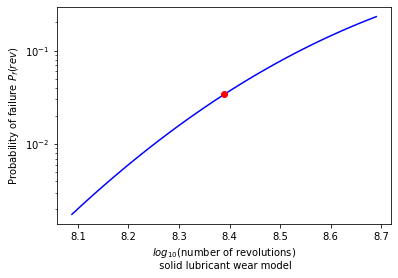

In [5]:
interact(proF, E_Vlim='6.5e-8', COV_Vlim='0.2', Dist_Vlim={'LogNormal', 'Normal','Gumbel'}, E_KH='4e-15', COV_KH='0.66', Dist_KH={'LogNormal', 'Normal','Gumbel'}, E_alpha='0.018', COV_alpha='0.2', Dist_alpha={'LogNormal', 'Normal','Gumbel'}, E_MU='1.2', COV_MU='0.2', Dist_MU={'LogNormal', 'Normal','Gumbel'}, E_nrev='245e+6');